Import Libraries and Dependencies

In [206]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score

def set_random_seeds(seed=30):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seeds()

 Find 256 random sensors locations (uniform distribution) in the circular area.

In [207]:
def find_sensor_locations(num_sensors, radius):
    """
    Finds the random locations of the sensors in the sensor network.
    """
    # Sample theta from a uniform distribution between 0 and 2*pi
    theta = np.random.uniform(0, 2*np.pi, num_sensors)

    #rad = np.sqrt(np.random.uniform(0, 1, num_sensors)) * radius
    # Sample r from a uniform distribution between 0 and radius
    r = np.sqrt(np.random.uniform(0, 1, num_sensors)) * radius
    x = r * np.cos(theta)
    y = r * np.sin(theta)

    sensor_locations = np.vstack((x, y)).T
    return sensor_locations

 Find the sensor adjacency matrix if sensors can communicate over 'u' meter

In [208]:
def find_adjacency_matrix(sensor_locs, u):
    """
    Finds the adjacency matrix of the sensor network.
    """
    matrix = np.zeros((len(sensor_locs), len(sensor_locs)))
    for i in range(len(sensor_locs)):
        for j in range(i+1, len(sensor_locs)):
            distance = np.linalg.norm(sensor_locs[i] - sensor_locs[j])
            if distance <= u:
                matrix[i, j] = matrix[j, i] = 1
    return matrix



Construct a (nonneural) algorithm to create a dataset of random walks from
the center. Check for nearest sensor location after each random-walk step.
Make the steps s small so the tiger can’t skip past sensors.


In [209]:
def simulate_random_walk(step_size, sensor_locs, detection_range, radius, direction_bias= 0.25):
    visited_sensors = set()
    x, y = 0, 0
    tig_pos = [(0, 0)]
    theta = np.random.uniform(0, 2*np.pi)
    edge = False

    while not edge:
        theta += np.random.uniform(-direction_bias * np.pi, direction_bias * np.pi)
        x += step_size * np.cos(theta)
        y += step_size * np.sin(theta)
        tig_pos.append((x, y))

        # Check if the tiger is detected by any sensor
        for i, sensor in enumerate(sensor_locs):
            if np.linalg.norm(np.array([x, y]) - sensor) <= detection_range:
                visited_sensors.add(i)

        if (x ** 2 + y ** 2) ** 0.5 > radius:
            edge = True

    return np.array(tig_pos), visited_sensors

def check_sensor_f_positive(visited_sensors, num_sensors, false_positive_prob):
    false_positives = set()
    for i in range(num_sensors):
        if i not in visited_sensors and np.random.rand() < false_positive_prob:
            false_positives.add(i)
    return visited_sensors.union(false_positives), false_positives

Define an objective and train a GNN that provides as output for each sensor
the probability p(ci = 1), where ci ∈ {1, 0} (tiger visited/tiger did not visit).


In [210]:
class GNNModel(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(GNNModel, self).__init__()
        self.conv1 = GATConv(in_channels, 8, heads=8, dropout=0.2)
        self.conv2 = GATConv(8 * 8, out_channels, heads=1, concat=False, dropout=0.2)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)
    
class GNNModel2(nn.Module):
    def __init__(self, num_features, num_classes):
        super(GNNModel2, self).__init__()
        self.fc1 = nn.Linear(num_features, 16)
        self.fc2 = nn.Linear(16, num_classes)

    def forward(self, x, edge_index):
        x = torch.relu(self.fc1(x))
        x = torch.matmul(edge_index, x)
        x = torch.sigmoid(self.fc2(x))
        return x


def train_gnn(model, data, labels, epochs=500):
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.BCELoss()
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        #out = model(data['x'], data['edge_index'])
        loss = criterion(out.squeeze(), labels)
        loss.backward()
        optimizer.step()
    return model

def evaluate_gnn(model, data, labels):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        #out = model(data['x'], data['edge_index'])
    predictions = (out.squeeze() > 0.5).float()
    acc = accuracy_score(labels, predictions)
    recall = recall_score(labels, predictions)
    precision = precision_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    roc_auc = roc_auc_score(labels, predictions)
    return acc, predictions, recall, precision, f1, roc_auc

Plot Method


In [211]:
# Plot the graph with the tiger's path
def plot_graph(sensor_locations, true_positives, false_positives, tiger_path):
    plt.figure(figsize=(10, 10))
    
    # Plot the circle
    circle = plt.Circle((0, 0), 1000, color='blue', fill=False)
    plt.gca().add_artist(circle)
    
    # Plot the sensors
    plt.scatter(sensor_locations[:, 0], sensor_locations[:, 1], color='skyblue', s=30, label='Sensors')
    
    # Highlight true positive sensors
    if true_positives is not None:
        plt.scatter(sensor_locations[list(true_positives), 0], sensor_locations[list(true_positives), 1], color='red', s=30, label='True Positives')
    
    # Highlight false positive sensors
    if false_positives is not None:
        plt.scatter(sensor_locations[list(false_positives), 0], sensor_locations[list(false_positives), 1], color='yellow', s=30, label='False Positives')
    
    # Highlight sensors that haven't been visited
    all_positives = true_positives.union(false_positives)
    not_visited = set(range(len(sensor_locations))) - all_positives
    plt.scatter(sensor_locations[list(not_visited), 0], sensor_locations[list(not_visited), 1], color='green', s=30, label='Not Visited')
    
    # Plot the tiger's path
    plt.plot(tiger_path[:, 0], tiger_path[:, 1], color='orange', linewidth=1, label='Tiger Path')
    #plt.scatter(tiger_path[:, 0], tiger_path[:, 1], color='orange', s=10)
    
    plt.legend()
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Sensor Network and Tiger Path')
    plt.grid(True)
    plt.axis('equal')
    plt.show()

def plot_predicted_graph(sensor_locations, tiger_path, predictions):
    plt.figure(figsize=(10, 10))
    
    # Plot the circle
    circle = plt.Circle((0, 0), 1000, color='blue', fill=False)
    plt.gca().add_artist(circle)
    
    # Plot the sensors
    plt.scatter(sensor_locations[:, 0], sensor_locations[:, 1], color='green', s=30, label='Sensors')

    # Highlight predicted positive sensors
    print(predictions)

    if predictions is not None:
        predicted_positives = set(np.where(predictions == 1)[0])
        plt.scatter(sensor_locations[list(predicted_positives), 0], sensor_locations[list(predicted_positives), 1], color='purple', s=35, label='Predicted Positives')
    
    # Plot the tiger's path
    plt.plot(tiger_path[:, 0], tiger_path[:, 1], color='orange', linewidth=1, label='Tiger Path')
    
    plt.legend()
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Predicted Sensor Positives')
    plt.grid(True)
    plt.axis('equal')
    plt.show()

def plot_performance_metrics(detection_ranges, accuracies, precisions, recalls, f1_scores):
    plt.figure(figsize=(5, 5))
    plt.plot(detection_ranges, accuracies, label='Accuracy', marker='o')
    plt.plot(detection_ranges, precisions, label='Precision', marker='o')
    plt.plot(detection_ranges, recalls, label='Recall', marker='o')
    plt.plot(detection_ranges, f1_scores, label='F1 Score', marker='o')
    plt.xlabel('Detection Range (d)')
    plt.ylabel('Performance Metrics')
    plt.title('Performance as a Function of Detection Range')
    plt.legend()
    plt.grid(True)
    plt.show()

C:\Users\Bendo\AppData\Local\Temp\ipykernel_30088\2777338805.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float)
c:\Users\Bendo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.8008


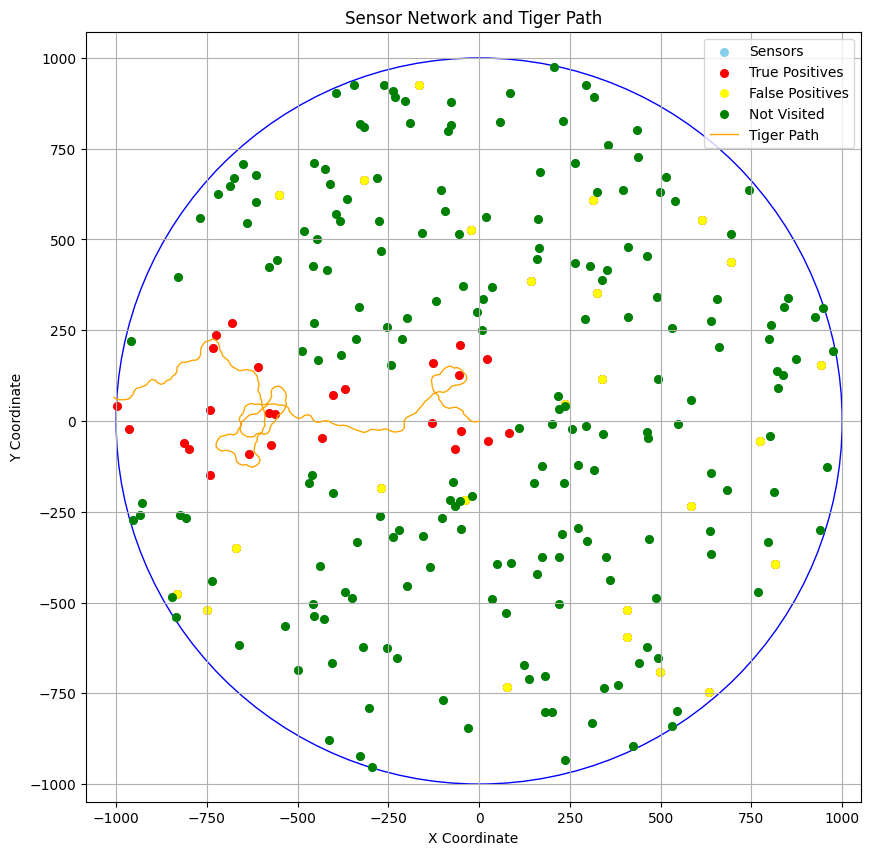

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

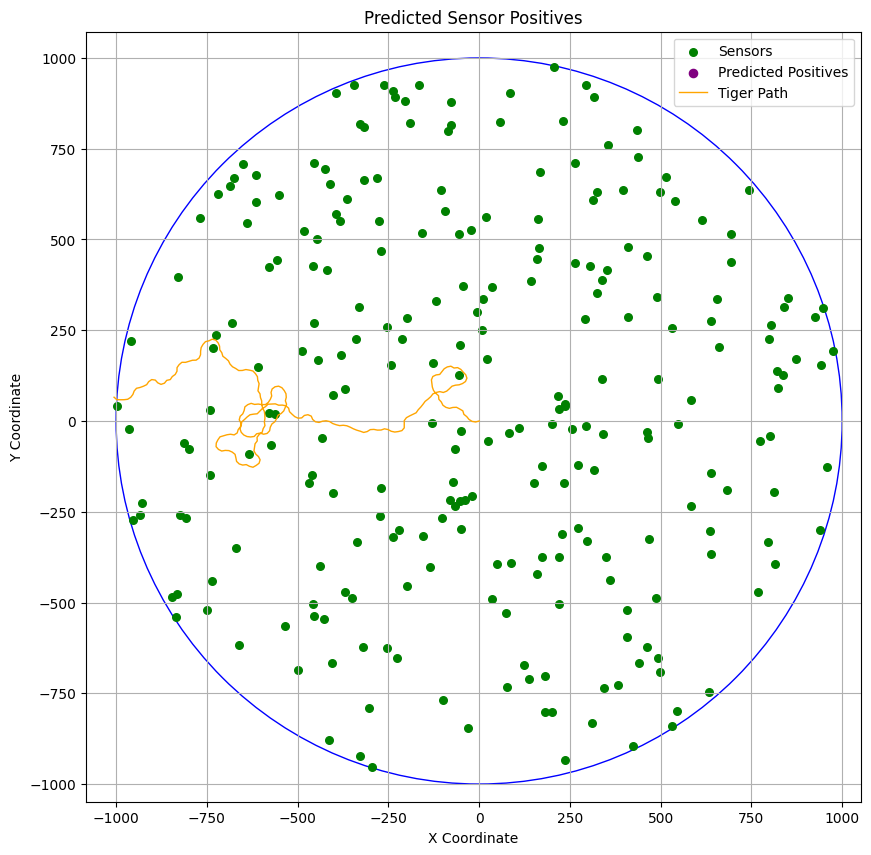

In [212]:
# Tiger sensor and Radius
num_sensors = 256
radius = 1000
# Probability of false positives
false_prob = 0.1
# step size
step_size = 10
# detection range
detection_range = 100
# communication range
com_range = 300

sensor_locs = find_sensor_locations(num_sensors, radius)
adj_matrix = find_adjacency_matrix(sensor_locs, com_range)
tiger_path, visited_sensors = simulate_random_walk(step_size, sensor_locs, detection_range, radius)
visited_sensors, false_positives = check_sensor_f_positive(visited_sensors, num_sensors, false_prob)

labels = torch.zeros(num_sensors)
labels[list(visited_sensors)] = 1

x = torch.tensor(sensor_locs, dtype=torch.float)
#edge_index = torch.tensor(np.array(np.nonzero(adj_matrix)), dtype=torch.long)
edge_index = torch.tensor(np.argwhere(adj_matrix == 1), dtype=torch.long).t().contiguous()
#edge_index = torch.tensor(adj_matrix, dtype=torch.float32)

data = Data(x=x, edge_index=edge_index)
#data = {'x': x, 'edge_index': edge_index}
labels = torch.tensor(labels, dtype=torch.float)

model = GNNModel(in_channels=2, out_channels=1)
model = train_gnn(model, data, labels)
# model = GNNModel2(num_features=2, num_classes=1)
# model = train_gnn(model, data, labels)
acc, predictions, recall, precision, f1, roc_auc = evaluate_gnn(model, data, labels)

print('Accuracy: {:.4f}'.format(acc))

plot_graph(sensor_locs, visited_sensors, false_positives, tiger_path)
plot_predicted_graph(sensor_locs, tiger_path, predictions)

In [213]:

# detection_ranges = [200, 150, 100, 50, 25]
# communication_ranges = [50, 100, 150, 200, 250]
# q_ranges = [0.1, 0.2, 0.3]
# accuracies, precisions, recalls, f1_scores = [], [], [], []

# for d in detection_ranges:
#     tig_pos, visited_sensors = simulate_random_walk(step_size, sensor_locs, d, radius)
#     visited_sensors, false_positives = check_sensor_f_positive(visited_sensors, 256, 0.1)
#     labels = np.zeros(256)
#     labels[list(visited_sensors)] = 1

#     data = Data(x=torch.tensor(sensor_locs, dtype=torch.float).unsqueeze(1),
#                 edge_index=torch.tensor(np.array(np.nonzero(adj_matrix)), dtype=torch.long))
#     labels = torch.tensor(labels, dtype=torch.float)

#     model = GNNModel(in_channels=1, out_channels=1)
#     model = train_gnn(model, data, labels)
#     acc, predictions, recall, precision, f1, roc_auc = evaluate_gnn(model, data, labels)

#     accuracies.append(acc)
#     precisions.append(precision)
#     recalls.append(recall)
#     f1_scores.append(f1)

# plot_performance_metrics(detection_ranges, accuracies, precisions, recalls, f1_scores)